In [1]:
import numpy as np
from numpy import polyfit
import matplotlib.pyplot as plt
import pickle
from astropy.io import fits
from scipy.optimize import minimize
from scipy.fft import rfft, rfftfreq
from scipy.stats import linregress
from astropy.timeseries import LombScargle as LS
import matplotlib.gridspec as gridspec
from scipy.signal import argrelmax

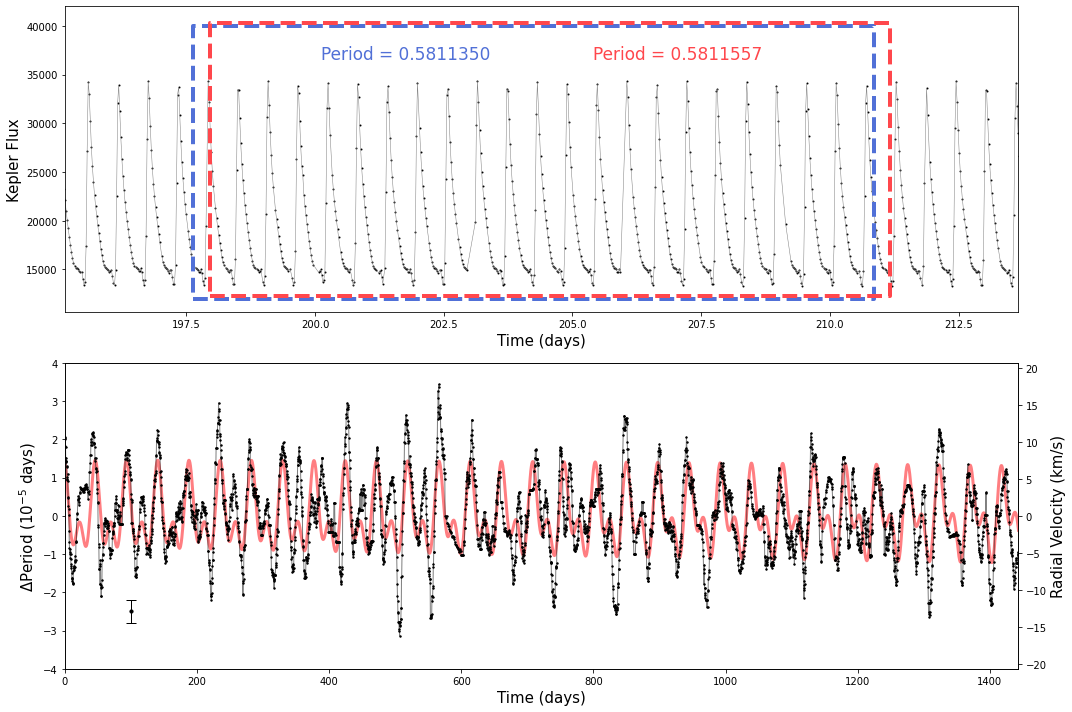

In [14]:
#=================================
# FIGURE 1
#=================================

#this is a helper function for reading in SPEX light curve data
def get_data_from_fits_pdm(filename, len_segment=600, scan_shift=15):
    #len_segment: number of measurements to put in one segment
    #scan_shift: number of measurements to shift between scans

    #load in all the data and build the dictionaries
    data = {}
    times = []
    fluxes = []
    
    id_tracker = 0
    #should do splits as a uniform amount of time, not n splits per data set
    with open(filename) as f:

        #remove header
        for i in range(3):
            f.readline()

        #read in data
        for line in f:
            line = line.split()
            times.append(float(line[1]))
            fluxes.append(float(line[5]))

    #print('data read in successfully')
    
    i = 0
    while i + len_segment < len(times):
        data[i] = {
                   'times' : times[i:i+len_segment],
                   'fluxes' : fluxes[i:i+len_segment]
        }
        i += scan_shift

    
    #print(len(data.keys()), 'scans' )
    
    return data

#---------------------------

star_id = '007988343'
filename = f"/home/donlon/Desktop/data/kepler_data/SPEX/nonBL/table_kplr007988343.tailor-made.dat"

#get the light curve data
data = get_data_from_fits_pdm(filename, len_segment=600, scan_shift=15)

#read in reduced p(t) data
with open(f"/home/donlon/Desktop/data/pickle/maps/maps_v1.1/best_periods_{star_id}_ls600_ss15.pickle", 'rb') as p:
    fit_periods = np.array(pickle.load(p))

x = [np.nanmean(data[key]['times']) for key in data.keys()]
x = x - min(x)

times = np.append(data[2400]['times'], data[3000]['times'])
fluxes = np.append(data[2400]['fluxes'], data[3000]['fluxes'])

fig, axs = plt.subplots(2, 1, figsize=(15,10))

ax = axs[0] #top panel

#plot
ax.scatter(times, fluxes, c='k', s=1)
ax.plot(times, fluxes, c='gray', lw=0.5)
ax.set_xlim(min(data[2655]['times']) - 2.5, max(data[2670]['times']) + 2.5)
ax.set_ylim(min(fluxes)*0.8, 42000)
ax.set_ylabel('Kepler Flux', fontsize=15)
ax.set_xlabel('Time (days)', fontsize=15)

left = min(data[2655]['times'])
right = max(data[2655]['times'])
top = 40000
bottom = 12000
ax.plot([left, right, right, left, left], [bottom, bottom, top, top, bottom], ls='--', c='xkcd:cornflower blue', lw=4)

left = min(data[2670]['times'])
right = max(data[2670]['times'])
top = 40000+300
bottom = 12000+300
ax.plot([left, right, right, left, left], [bottom, bottom, top, top, bottom], ls='--', c='xkcd:light red', lw=4)

midpoint = (max(data[2670]['times']) + min(data[2655]['times']))/2
ax.text(midpoint - 1, 38000, f"Period = 0.5811350", color='xkcd:cornflower blue', fontsize=17,
        verticalalignment='top', horizontalalignment='right')
ax.text(midpoint + 1, 38000, f"Period = 0.5811557", color='xkcd:light red', fontsize=17,
        verticalalignment='top', horizontalalignment='left')

ax = axs[1] #bottom panel

#set up for LSP
frequency = np.linspace(0.001, 0.2, 100000)
power = LS(x, np.array(fit_periods), center_data=True).power(frequency)
pgram_per = 1/frequency

#compute part of oscillations from the planets and build the 2-companion model
indx = np.intersect1d(argrelmax(power),np.where(power > 0.15)[0])
ls = LS(x, np.array(fit_periods), center_data=True)
y_fit = np.zeros(len(x))
for j in range(len(indx)):
    params = ls.model_parameters(frequency[indx][j])
    y_fit += (params[1]*np.sin(2*np.pi*frequency[indx][j]*x) + params[2]*np.cos(2*np.pi*frequency[indx][j]*x))
y_fit += np.mean(fit_periods)

#plot
ax.scatter(x, (fit_periods - np.mean(fit_periods))/1e-5, s=2, c='k', zorder=9)
ax.plot(x, (fit_periods - np.mean(fit_periods))/1e-5, c='k', lw=1, zorder=8, alpha=0.5)
ax.plot(x, (y_fit - np.mean(fit_periods))/1e-5, c='xkcd:light red', lw=3, alpha=0.7)

ax.errorbar([100], [-2.5], yerr=0.000003/1e-5, c='k', lw=1, capsize=5)
ax.scatter([100], [-2.5], c='k', s=10)
ax.set_xlim(min(x), max(x))
ax.set_ylabel('$\Delta$Period (10$^{-5}$ days)', fontsize=15)
ax.set_xlabel('Time (days)', fontsize=15)
ax.set_ylim(-4, 4)

#add radial velocity axis on right side of plot
ax2 = ax.twinx()
ax2.plot([-999, -999], [-999, -999])
ax2.set_ylim(-4e-5/np.mean(fit_periods)*3e5, 4e-5/np.mean(fit_periods)*3e5)
ax2.set_ylabel('Radial Velocity (km/s)', fontsize=15)

plt.tight_layout()
plt.show()

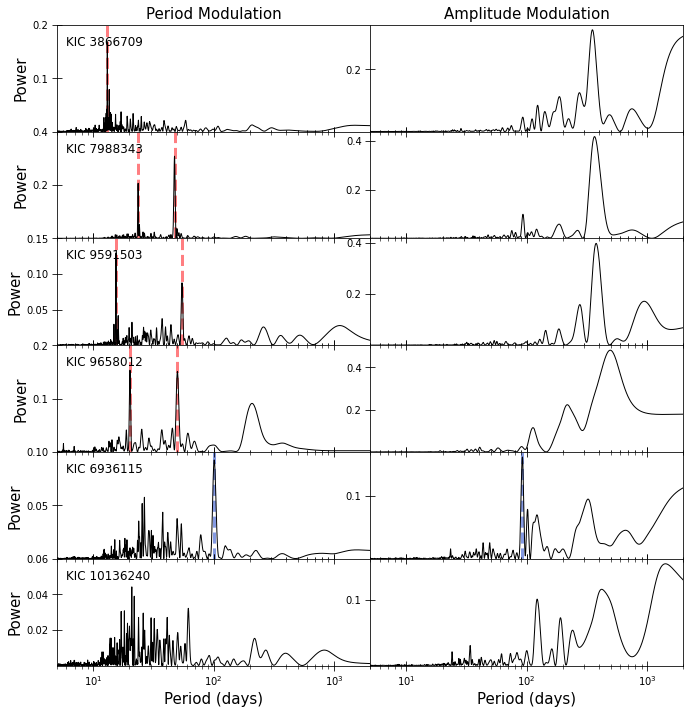

In [19]:
#=================================
# FIGURE 2
#=================================

frequency = np.linspace(0.0005, 0.2, 100000)
pgram_per = 1/frequency


#helper function to reduce data into LSP
def analysis(star_id):

    #read in data
    filename = f"/home/donlon/Desktop/data/kepler_data/SPEX/nonBL/table_kplr{star_id}.tailor-made.dat"
    data = get_data_from_fits_pdm(filename, len_segment=600, scan_shift=15)

    with open(f"/home/donlon/Desktop/data/pickle/maps/maps_v1.1/best_periods_{star_id}_ls600_ss15.pickle", 'rb') as p:
        fit_periods = np.array(pickle.load(p))

    x = [np.nanmean(data[key]['times']) for key in data.keys()]
    x = x - min(x)
    
    #make LSPs
    amp_arr = []
    for key in data:
        amp = max(data[key]['fluxes']) - min(data[key]['fluxes'])
        amp_arr.append(amp)
    amp_arr = np.array(amp_arr)
    
    if star_id == '009591503': #special case bc the data is fucked
        x = x[:-200]
        fit_periods = fit_periods[:-200]
        amp_arr = amp_arr[:-200]

    #cut bad points
    indx = np.logical_not(np.isnan(fit_periods))*\
            np.logical_not(np.isnan(amp_arr))*\
           (np.abs(np.array(fit_periods) - np.nanmean(fit_periods)) < 3*np.nanstd(fit_periods))*\
           (np.abs(np.array(amp_arr) - np.nanmean(amp_arr)) < 3*np.nanstd(amp_arr))

    x = x[indx]
    fit_periods = fit_periods[indx]
    amp_arr = amp_arr[indx]

    per_power = LS(x, np.array(fit_periods), center_data=True).power(frequency)
    amp_power = LS(x, np.array(amp_arr), center_data=True).power(frequency)

    return x, fit_periods, per_power, amp_arr, amp_power

#----------------------------------
    
#what stars we are plotting
star_ids_list = [
            '003866709',
            '007988343',
            '009591503',
            '009658012',
            '006936115',
            '010136240'
            ]

companion_pers = [
            [13.11],
            [23.62, 47.41],
            [15.48, 54.73],
            [20.23, 50.11],
            [],
            []
            ]

#plotting
fig, axs = plt.subplots(6, 2, figsize=(10,10))

for i, s in enumerate(star_ids_list):
    x, fit_periods, per_power, amp_arr, amp_power = analysis(s)
    
    #-----------------------
    
    ax = axs[i,0]
    
    ax.plot(pgram_per, per_power, c='k', lw=1, zorder=2)
    
    ax.set_xscale('log')
    ax.set_xlim(5, 2000)
    ax.set_ylim(0, None)
    ax.set_ylabel('Power', fontsize=15)
    ax.tick_params(direction='inout', which='both', labelbottom=False, top=True)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=5)
    ax.set_yticks(ax.get_yticks()[1:])
    
    ax.text(6, ax.get_ylim()[1]*0.9, 
        f"KIC {int(s)}",
        fontsize=12,
        horizontalalignment='left', verticalalignment='top')
    
    if i == 4:
            ax.plot([101.29, 101.29], [0, ax.get_ylim()[1]], c='xkcd:cornflower blue', ls='--', lw=3, zorder=1, alpha=0.7)
    else:
        for per in companion_pers[i]:
            ax.plot([per, per], [0, ax.get_ylim()[1]], c='xkcd:light red', ls='--', lw=3, zorder=1, alpha=0.7)
    
    #-----------------------
    
    ax = axs[i,1]
    
    ax.plot(pgram_per, amp_power, c='k', lw=1)
    
    ax.set_xscale('log')
    ax.set_xlim(5, 2000)
    ax.set_ylim(0, None)
    #ax.set_ylabel('Power', fontsize=15)
    #ax.set_xlabel('Period (days)', fontsize=15)
    #ax.set_ylim(0, 0.5)
    ax.tick_params(direction='inout', which='both', labelbottom=False, top=True)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=5)
    ax.set_yticks(ax.get_yticks()[1:-1])
    
    if i == 4:
        ax.plot([92.03, 92.03], [0, ax.get_ylim()[1]], c='xkcd:cornflower blue', ls='--', lw=3, zorder=1, alpha=0.7)
    
    #-----------------------
    
axs[0,0].tick_params(top=False, which='both')
axs[0,1].tick_params(top=False, which='both')
axs[0,0].set_title('Period Modulation', fontsize=15)
axs[0,1].set_title('Amplitude Modulation', fontsize=15)
axs[5,0].set_xlabel('Period (days)', fontsize=15)
axs[5,1].set_xlabel('Period (days)', fontsize=15)
axs[5,0].tick_params(direction='inout', which='both', labelbottom=True)
axs[5,1].tick_params(direction='inout', which='both', labelbottom=True)

plt.subplots_adjust(wspace=0, hspace=0, left=0.08, right=0.95, top=0.95, bottom=0.06)
plt.show()

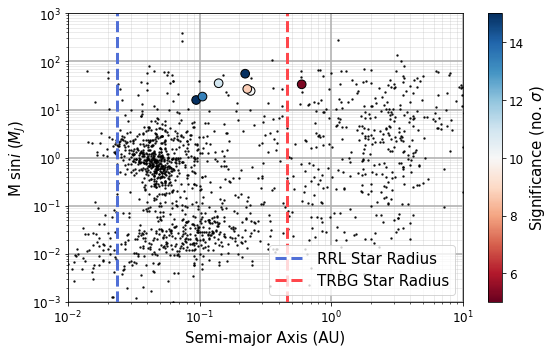

In [24]:
#=================================
# FIGURE 3
#=================================

#read in exoplanet db info
#(https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3hdprods.pl#exoplanets)
exoplanet_smas = []
exoplanet_masses = []
with open('/home/donlon/Desktop/data/exoplanet_db.csv', 'r') as f:
    f.readline()
    for line in f:
        line = line.strip().split(',')
        if line[0] != '' and line[1] != '':
            exoplanet_masses.append(float(line[0]))
            exoplanet_smas.append(float(line[1]))
            
#-------------------------------------

#these are pre-calculated from external analysis
all_sma = [0.09423655, 0.2220841, 0.13957303, 0.24438317, 0.10527994, 0.59669967, 0.23042154] #AU
all_mass = [15.77057197, 55.43375192, 35.15823185, 24.32200697, 18.58129668, 33.40831635, 26.75197241] #MJup
all_sig = [16.55218719, 17.02315432, 10.94637584, 10.00104628, 13.37963572, 5.29095801, 8.75547825]

fig, ax = plt.subplots(1, 1, figsize=(8, 5), tight_layout=True)

im = ax.scatter(all_sma, all_mass, c=all_sig, edgecolor='k', vmin=5, vmax=15, s=75, zorder=99, cmap='RdBu')
ax.scatter(exoplanet_smas, exoplanet_masses, c='k', s=2, zorder=2, alpha=0.8)
ax.grid(True, which='minor', lw=0.5, alpha=0.5)
ax.grid(True, which='major', lw=2, alpha=0.8)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Semi-major Axis (AU)', fontsize=15)
ax.set_ylabel('M $\sin i$ ($M_J$)', fontsize=15)

cbar = plt.colorbar(mappable=im, ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Significance (no. $\sigma$)', fontsize=15)

ax.plot([0.0237174, 0.0237174], [1e-3, 1e3], c='xkcd:cornflower blue', ls='--', lw=3, label='RRL Star Radius')
ax.plot([0.465047, 0.465047], [1e-3, 1e3], c='xkcd:light red', ls='--', lw=3, label='TRBG Star Radius')
ax.legend(loc='lower right', fontsize=15)

ax.set_xlim(1e-2, 1e1)
ax.set_ylim(1e-3, 1e3)
ax.tick_params(labelsize=12)

plt.show()